# Test of "filter" and "filtfilt" Functions from Ardour

| Resources | Links |
| --- | --- |
| Ardour open source code:        | https://github.com/djpohly/ardour/tree/master/libs/qm-dsp/dsp/signalconditioning |
| MATLAB filtfilt function info:  | https://de.mathworks.com/help/signal/ref/filtfilt.html |
| MATLAB filtfilt source code:    | type "open filtfilt" in MATLAB command window...  |
| SciPy filfilt open source code: |https://github.com/scipy/scipy/blob/master/scipy/signal/signaltools.py |

### Introduction

This notebook is used to show the results of the "filter" and "filtfilt" function implementations in Python and CodeSys. The implementation of both functions (in Python and CodeSys) is done according to the open source code of Ardour (see link above).
<br><br>
For analyzing purposes a noisy sine wave is generated in MATLAB and used as an input sequence for the following filter comparison task. The generated noisy sine wave is then filtered with an FIR filter (Butterworth filter of order 9 designed in MATLAB), which is implemented in form of a discrete transfer function. Eventually, the filtering results of the "filter" and "filtfilt" functions of MATLAB, Python and CodeSys are comparised.

### Import Packages and load Data Set

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# data path for matlab data
data_path = os.path.join( os.getcwd(), 'data', 'matlab_sine_data_lowNoise.CSV')
filter_path = os.path.join( os.getcwd(), 'data', 'matlab_sine_filter_lowNoise.CSV')

# load matlab results as pandas Dataframe
df_matlab_results = pd.read_csv(data_path, sep=';')
df_filter = pd.read_csv(filter_path, sep=';')

df_matlab_results.head(10)

,index,wform,noise,wform_noisy,y_filtfilt,y_filter
0,1,0.000000,-0.043256,-0.043256,-0.043218,-0.000090
1,2,0.062759,-0.166558,-0.103800,0.002487,-0.001118
2,3,0.125270,0.012533,0.137803,0.066046,-0.005939
3,4,0.187287,0.028768,0.216055,0.155193,-0.016917
4,5,0.248566,-0.114647,0.133919,0.262306,-0.024279
5,6,0.308866,0.119092,0.427957,0.366585,0.001651
6,7,0.367947,0.118916,0.486863,0.444459,0.086552
7,8,0.425578,-0.003763,0.421814,0.485492,0.212294
8,9,0.481530,0.032729,0.514260,0.503442,0.326601
9,10,0.535585,0.017464,0.553049,0.529282,0.402811


In [3]:
df_filter.head(10)

,index,num_filt,den_filt
0,1,0.002070,1.000000
1,2,0.018632,-1.089295
2,3,0.074529,1.692510
3,4,0.173900,-1.080412
4,5,0.260850,0.732861
5,6,0.260850,-0.272224
6,7,0.173900,0.091650
7,8,0.074529,-0.017383
8,9,0.018632,0.002388
9,10,0.002070,-0.000132


In [4]:
index = df_matlab_results.index.values.flatten()                    # index of dataframe entries (0 - 1001)
inputSignal = df_matlab_results.wform.values.flatten()              # base signal: ECG-Waveform without noise
inputSignal_noisy = df_matlab_results.wform_noisy.values.flatten()  # input signal for analysis: ECG-Waveform with noise
y_matlabFiltFilt = df_matlab_results.y_filtfilt.values.flatten()    # MATLAB "filtfilt" function results for input signal
y_matlabFilter = df_matlab_results.y_filter.values.flatten()        # MATLAB "filter" function results for input signal
num_filt = df_filter.num_filt.values.flatten()  # numerator (B) of used filter (butterworth filter, order: 9)
den_filt = df_filter.den_filt.values.flatten()  # denominator (A) of used filter (butterworth filter, order: 9)

In [5]:
# round data to 6 significant digits:
significant_digits = 6

inputSignal = inputSignal.round(significant_digits)
inputSignal_noisy = inputSignal_noisy.round(significant_digits)
y_matlabFiltFilt = y_matlabFiltFilt.round(significant_digits)
y_matlabFilter = y_matlabFilter.round(significant_digits)
num_filt = num_filt.round(significant_digits)
den_filt = den_filt.round(significant_digits)


Filter transter function of the filter (Butterworth filter of 9th order): <br><br>
$$
G(s) =\frac{B(s)}{A(s)} = \frac{0.00207s^9 + 0.018632s^8 + 0.074529s^7 + 0.1739s^6 + 0.26085s^5 + 0.26085s^4 + 0.1739s^3 + 0.074529s^2 + 0.018632s + 0.00207}{s^9 -1.089295s^8 + 1.69251s^7 -1.080412s^6 +0.732861s^5 -0.27222s^4 + 0.09165s^3 -0.017383s^2 + 0.002388s - 0.000132}
$$
<br>

### Plot noisy sine signal (input data for filtering)

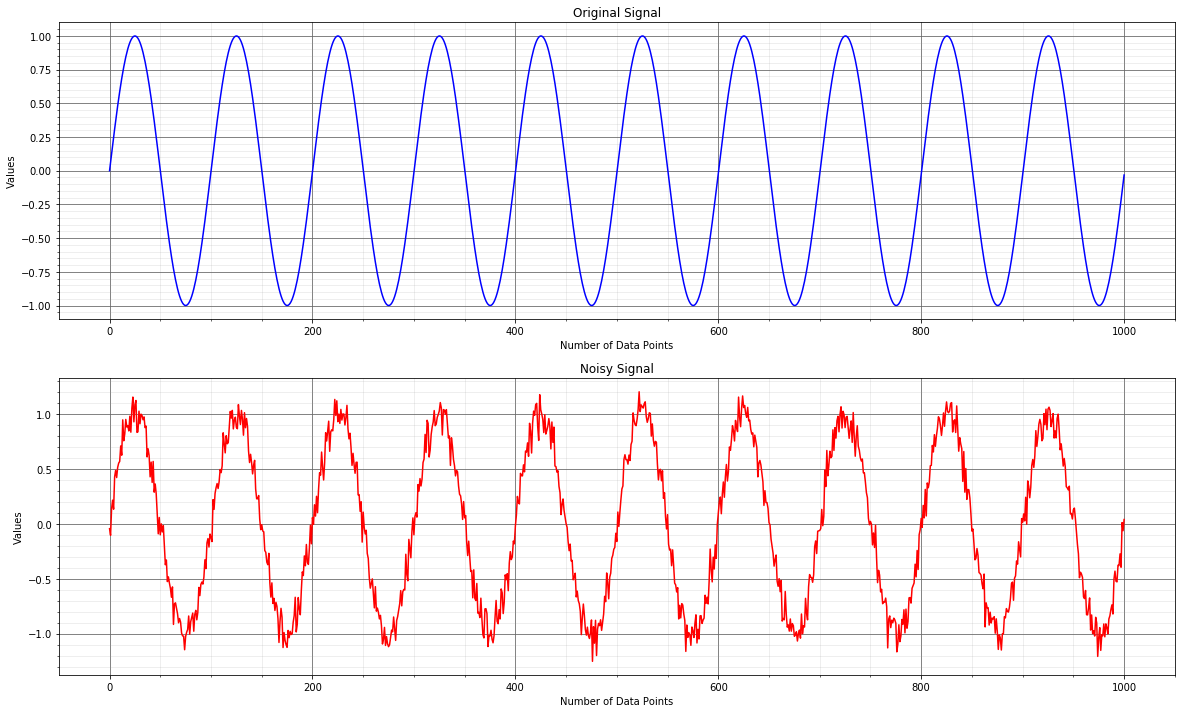

In [6]:
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,12))

ax0.plot(index, inputSignal, color='blue', label ='orginal signal')
ax1.plot(index, inputSignal_noisy, color='red', label ='noisy signal')

ax0.set_title('Original Signal')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Noisy Signal')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

## Independent implementations of the "filter" and "filtfilt" functions in Python

### Ardour "filter" Function (conventional filter with phase-distortion)

independent implementation of the "filter" function in respect to the open source code of Ardour

In [7]:
def filterArdour(filt_ord, filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    u = input_signal                # input signal
    length = input_signal_len       # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))         # output signal; initialize with zeros
    
    inBuffer = np.zeros((filt_ord+1,))  # buffer for input signal with window length of (filter_ord+1) ; initialize with zeros
    outBuffer = np.zeros((filt_ord+1,)) # buffer for output signal with window length of (filter_ord+1) ; initialize with zeros
    
    for j in range(0, length):

        # move input buffer and sample value of input signal (required for feedforward path of IIR-Filter)
        for i in range(0, filt_ord):
            inBuffer[filt_ord-i] = inBuffer[filt_ord-i-1]
        inBuffer[0] = u[j]   # sample input signal of current time step

        # reset output value for current time step
        y_temp = 0

        # calculate feedforward path (B of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp + filt_BCoeffs[i] * inBuffer[i]

        # calculate feedback path (A of IIR-Filter)
        for i in range(0, filt_ord):
            y_temp = y_temp - filt_ACoeffs[i+1] * outBuffer[i]

        # write calculated filter output of current time step into output array
        y[j] = y_temp

        # move output buffer and sample value of output signal (required for feedback path of IIR-Filter)
        for i in range(0, filt_ord-1):
            outBuffer[filt_ord-i-1] = outBuffer[filt_ord-i-2]
        outBuffer[0] = y_temp
    
    return y;


### Ardour "filtfilt" Function (conventional filter with phase-distortion)

independent implementation of the "filtfilt" function in respect to the open source code of Ardour

In [8]:
def filtfiltArdour(filt_ACoeffs, filt_BCoeffs, input_signal, input_signal_len):
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Variable initilization and preprocessing
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    u = input_signal            # input signal
    length = input_signal_len   # length of raw input signal (caution: length without edge reflections!, see function: filtfilt)
    y = np.zeros((length,))     # output signal; initialize with zeros
    
    filtACoeffs = filt_ACoeffs  # filter numerator coefficients
    filtBCoeffs = filt_BCoeffs  # filter denominator coefficients

    na = len(filtACoeffs)       # number of filter feedback coefficients (A)
    nb = len(filtBCoeffs)       # number of filter feedforward coefficients (B)
    nFilt = max(na,nb)          # max. number of given filter coefficients 
    filtOrd = nFilt - 1         # filter order
    nFact = 3 * ( nFilt - 1)    # length of edge transients ( 3 times filter order)
    nExt = length + 2 * nFact   # padding before and after signal
    
    sample0 = 2*u[0]            # used for edge transfer reflection
    sampleN = 2*u[length-1]     # used for edge transfer reflection
    index = 0;                  # index variable for loops
    filtScratchIn = np.zeros((nExt,))  # function intern input sequence 
    filtScratchOut = np.zeros((nExt,)) # function intern output sequence
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Edge Transfer Reflection
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # (info: Extrapolate beginning and end of data sequence using reflection. Slopes of original and extrapolated sequences
    #        match at end points, reducing transients.)
    
    #   starting edge transfer reflection
    for i in range(nFact, 0, -1):
        filtScratchIn[index] = sample0 - u[i]
        index = index + 1
        
    #   ending edge transfer reflection
    index = 0;
    for i in range(0, nFact):
        filtScratchIn[ (nExt - nFact) + index ] = sampleN - u[ (length - 2) - i ]
        index = index + 1
        
    # (normal/unedited) raw signal inbetween edge transfer padding
    for i in range(0, length):
        filtScratchIn[i + nFact] = u[i]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 1st filtering (forward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                            filt_ACoeffs = filtACoeffs, 
                            filt_BCoeffs = filtBCoeffs, 
                            input_signal = filtScratchIn, 
                            input_signal_len = nExt)    
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 2nd filtering (backward filtering)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #   reverse the filtered signal:
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    #   filter the reversed signal again (backward filtering)
    y_filtfiltArdour = filterArdour(filt_ord = filtOrd, 
                        filt_ACoeffs = filtACoeffs, 
                        filt_BCoeffs = filtBCoeffs, 
                        input_signal = filtScratchIn, 
                        input_signal_len = nExt)
    
    #   reverse the reversed signal again to get the normal signal
    for i in range(0, nExt):
        filtScratchIn[i] = y_filtfiltArdour[ nExt -i -1 ]
        
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Remove Edge Transients padding for Output Signal
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for i in range(0, length):
        y[i] = filtScratchIn[i + nFact]
        
    return y

## Test of the independent "filter" and "filtfilt" implementations, <br> in comparison to MATLAB outputs

#### Test of "filter" Function

In [10]:
y_filterArdour = filterArdour(
    filt_ord = 9, 
    filt_ACoeffs = den_filt, 
    filt_BCoeffs = num_filt, 
    input_signal = inputSignal_noisy, 
    input_signal_len = 1001)

# calculate error between MATLAB filter function and Ardour filter function
filter_error = np.abs(y_matlabFilter - y_filterArdour)

The following plot shows the output of the MATLAB "filter()" function in comparison to the output of the independently programmed Python filter function ("filterArdour"). Both filters are used with the same noisy sine wave input signal and the same butterworth FIR filter. <br><br>
One can see that the results are nearly equal. The independently implemented filter() function works well with FIR filters.

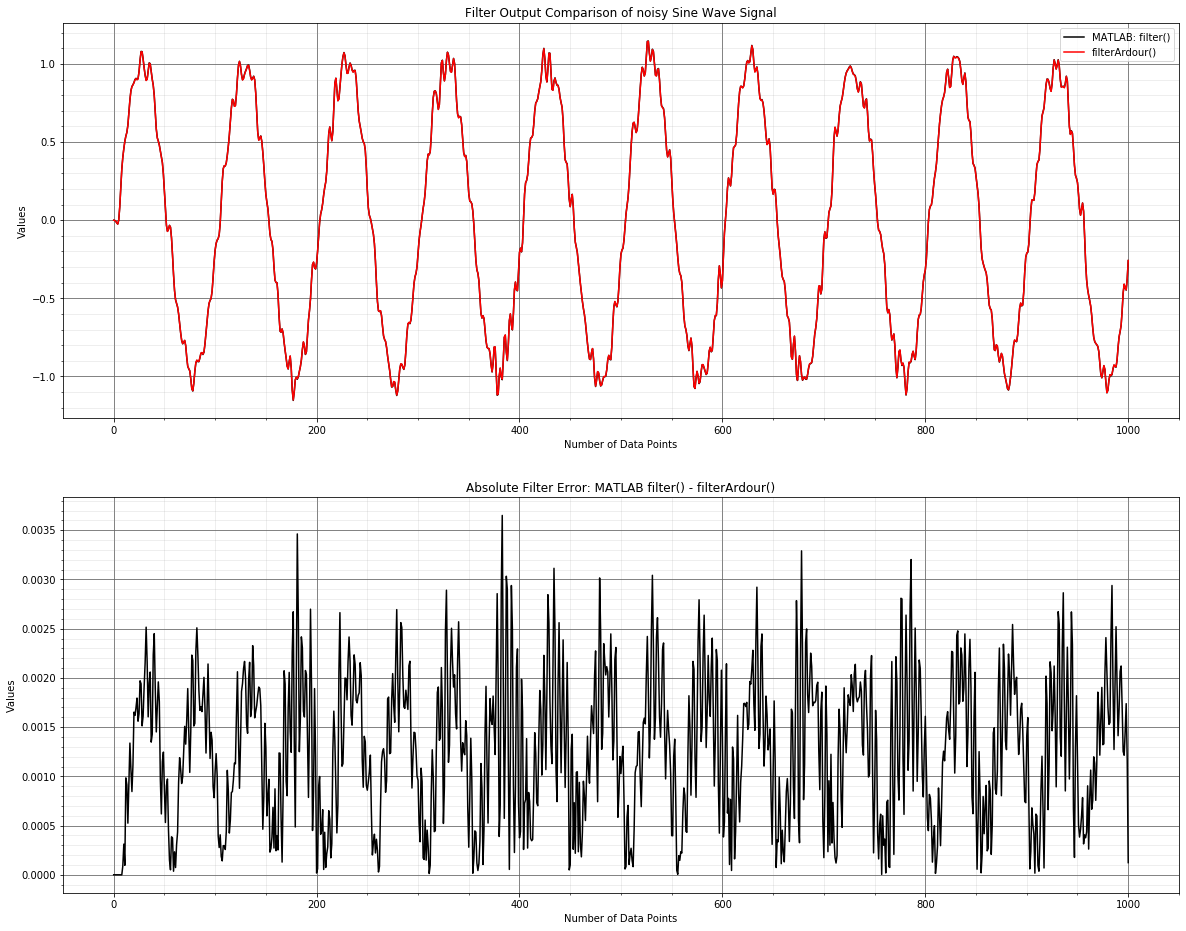

In [11]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(index, y_matlabFilter, color='black', label ='MATLAB: filter()')
ax0.plot(index, y_filterArdour, color='red', label ='filterArdour()')
ax1.plot(index, filter_error, color='black', label ='Filter Error')

ax0.set_title('Filter Output Comparison of noisy Sine Wave Signal')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Absolute Filter Error: MATLAB filter() - filterArdour()')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Test of "filtfilt" Function

In [12]:
y_filtfiltArdour = filtfiltArdour(
                            filt_ACoeffs = den_filt, 
                            filt_BCoeffs = num_filt, 
                            input_signal = inputSignal_noisy, 
                            input_signal_len = 1001)  

# calculate error between MATLAB filtfilt function and Ardour filtfilt function
filtfilt_error = np.abs(y_matlabFiltFilt) - np.abs(y_filtfiltArdour)

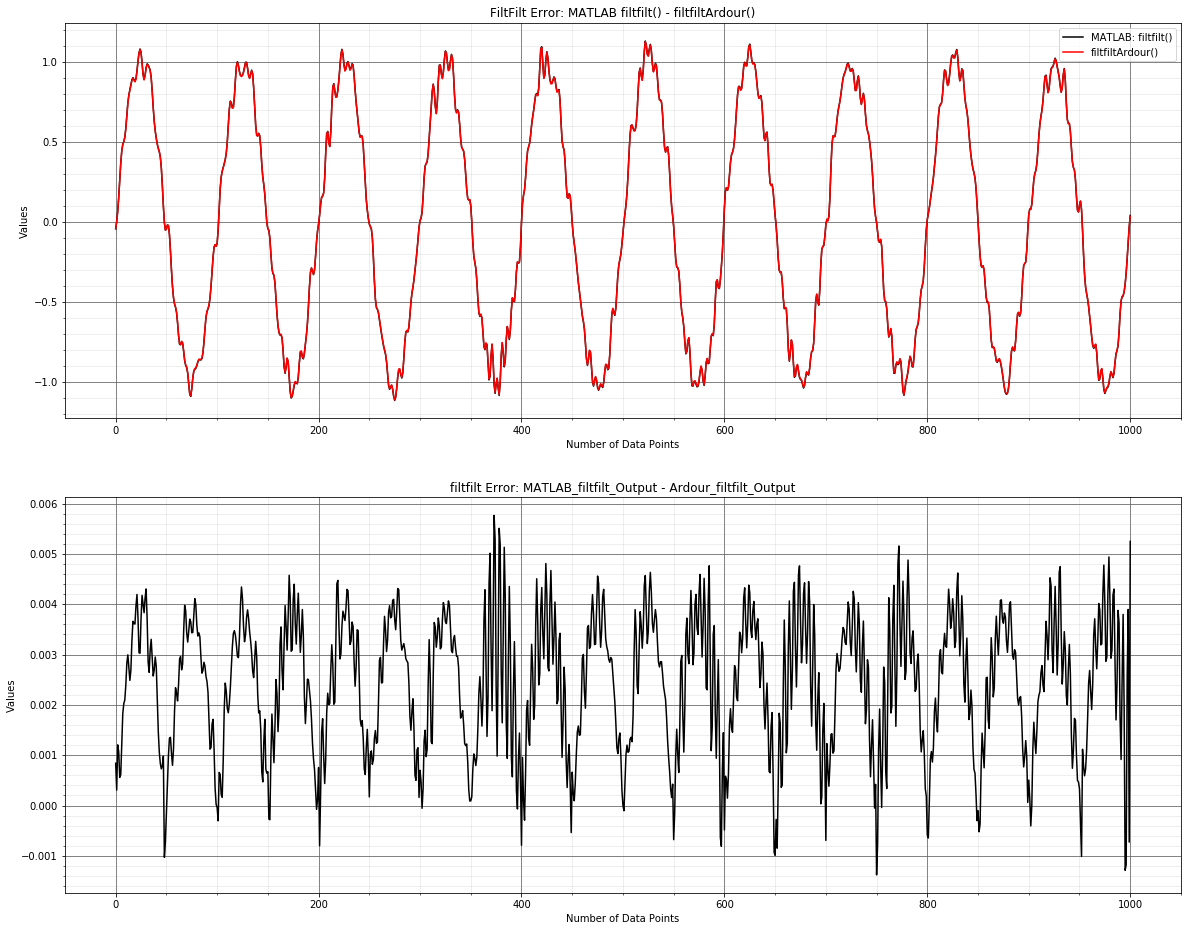

In [13]:
# plot comparison and error
fig, (ax0, ax1) = plt.subplots(2, figsize=(20,16))

ax0.plot(index, y_matlabFiltFilt, color='black', label ='MATLAB: filtfilt()')
ax0.plot(index, y_filtfiltArdour, color='red', label ='filtfiltArdour()')
ax1.plot(index, filtfilt_error, color='black', label ='FiltFilt Error')

ax0.set_title('FiltFilt Error: MATLAB filtfilt() - filtfiltArdour()')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('filtfilt Error: MATLAB_filtfilt_Output - Ardour_filtfilt_Output')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# Comparison of filtArdour() and filtfiltArdour()

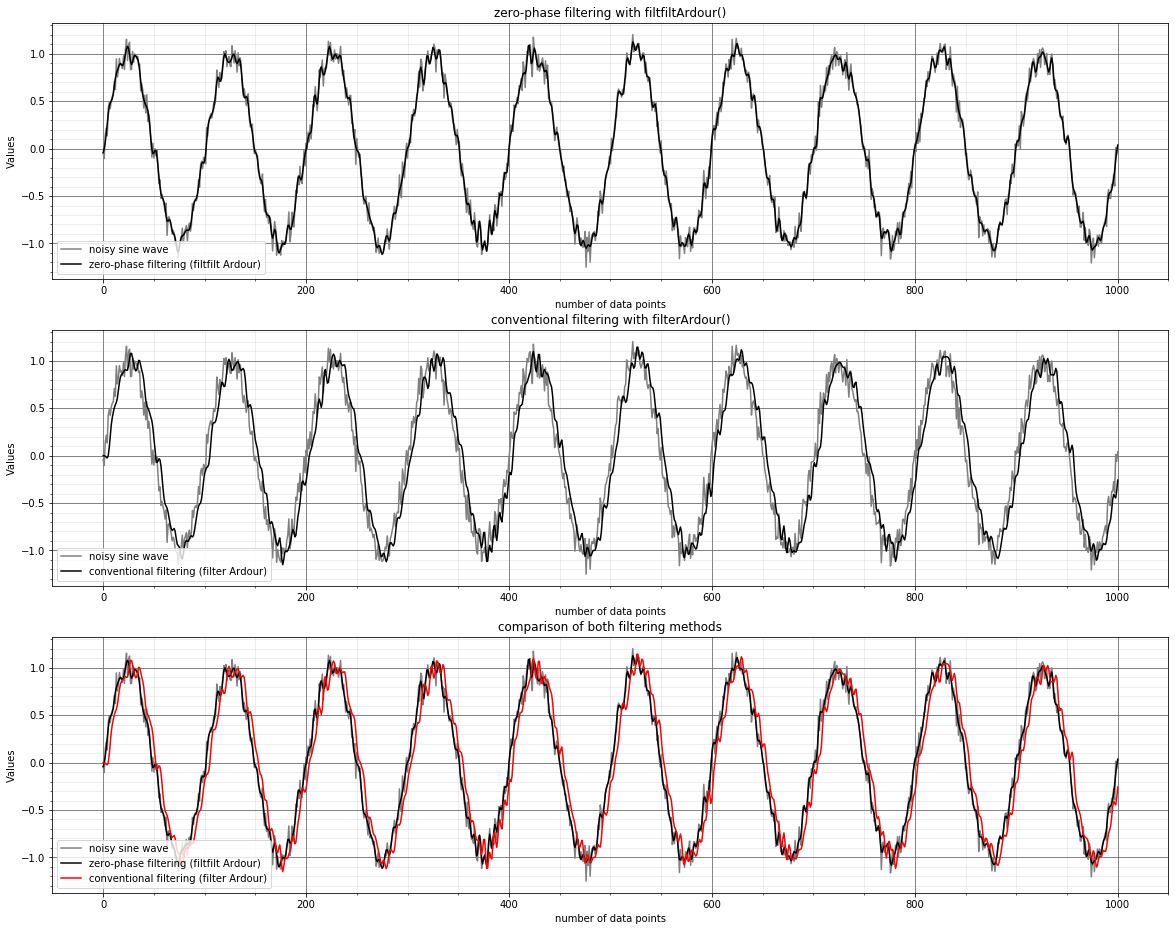

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(20,16))

ax0.plot(index, inputSignal_noisy, color='gray', label ='noisy sine wave')
ax0.plot(index, y_filtfiltArdour, color='black', label ='zero-phase filtering (filtfilt Ardour)')
ax1.plot(index, inputSignal_noisy, color='gray', label ='noisy sine wave')
ax1.plot(index, y_filterArdour, color='black', label ='conventional filtering (filter Ardour)')
ax2.plot(index, inputSignal_noisy, color='gray', label ='noisy sine wave')
ax2.plot(index, y_filtfiltArdour, color='black', label ='zero-phase filtering (filtfilt Ardour)')
ax2.plot(index, y_filterArdour, color='red', label ='conventional filtering (filter Ardour)')

ax0.set_title('zero-phase filtering with filtfiltArdour()')
ax0.set_xlabel('number of data points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('conventional filtering with filterArdour()')
ax1.set_xlabel('number of data points')
ax1.set_ylabel('Values')
ax1.legend()
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax2.set_title('comparison of both filtering methods')
ax2.set_xlabel('number of data points')
ax2.set_ylabel('Values')
ax2.legend()
ax2.grid(b=True, which='major', color='#666666', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

# CodeSys Filter and FiltFilt Results

CodeSys sine wave signal sequence: <br>
(copy paste into CodeSys -> ARRAY[0..1000] OF REAL := ... )

In [29]:
print(inputSignal_noisy.tolist())

[-0.043256, -0.1038, 0.137803, 0.216055, 0.133919, 0.427957, 0.486863, 0.421814, 0.51426, 0.553049, 0.568857, 0.709733, 0.625437, 0.947004, 0.756589, 0.820129, 0.950732, 0.881974, 0.895018, 0.846319, 0.980301, 0.834798, 1.053588, 1.154379, 0.928801, 1.085799, 1.123479, 0.832849, 0.838358, 1.025927, 0.911363, 0.999139, 0.986823, 0.948003, 0.973933, 0.876532, 0.890327, 0.609529, 0.68345, 0.622709, 0.428407, 0.562659, 0.377278, 0.568532, 0.288918, 0.363254, 0.272041, 0.096662, -0.090217, 0.058429, -0.099471, 0.000277, -0.072916, -0.01648, -0.187895, -0.37171, -0.328432, -0.525047, -0.482085, -0.539061, -0.586234, -0.667712, -0.573606, -0.914992, -0.726394, -0.718234, -0.770104, -0.817491, -0.899871, -0.861256, -0.893475, -0.993583, -1.019602, -1.021409, -1.145389, -1.023398, -0.986331, -0.960938, -0.838399, -1.004303, -0.889517, -0.850818, -0.811847, -0.976786, -0.824555, -0.786817, -0.873033, -0.805067, -0.578358, -0.652756, -0.551114, -0.529473, -0.547866, -0.484415, -0.326541, -0.40688

#### load data

In [25]:
data_path = os.path.join( os.getcwd(), 'data', 'CodeSys_Sine_results.CSV')
df_codesys_results = pd.read_csv(data_path, sep=';')
df_codesys_results.head(11)

,filter_output,filtfilt_output
0,-0.000090,-0.042378
1,-0.001118,0.002180
2,-0.005939,0.064841
3,-0.016917,0.154127
4,-0.024279,0.261748
5,0.001651,0.365973
6,0.086552,0.443215
7,0.212294,0.483666
8,0.326601,0.501418
9,0.402901,0.527184


In [27]:
y_codesysFilter = df_codesys_results.filter_output.values.flatten()
y_codesysFiltFilt = df_codesys_results.filtfilt_output.values.flatten()

codesys_filter_error_Ardour = np.abs(y_filterArdour[0:1000] - y_codesysFilter)
codesys_filter_error_Matlab = np.abs(y_matlabFilter[0:1000] - y_codesysFilter)

codesys_filtfilt_error_Ardour = np.abs(y_filtfiltArdour[0:1000] - y_codesysFiltFilt)
codesys_filtfilt_error_Matlab = np.abs(y_matlabFiltFilt[0:1000] - y_codesysFiltFilt)

### Plot comparison of MATLAB, Python and CodeSys "filter" results

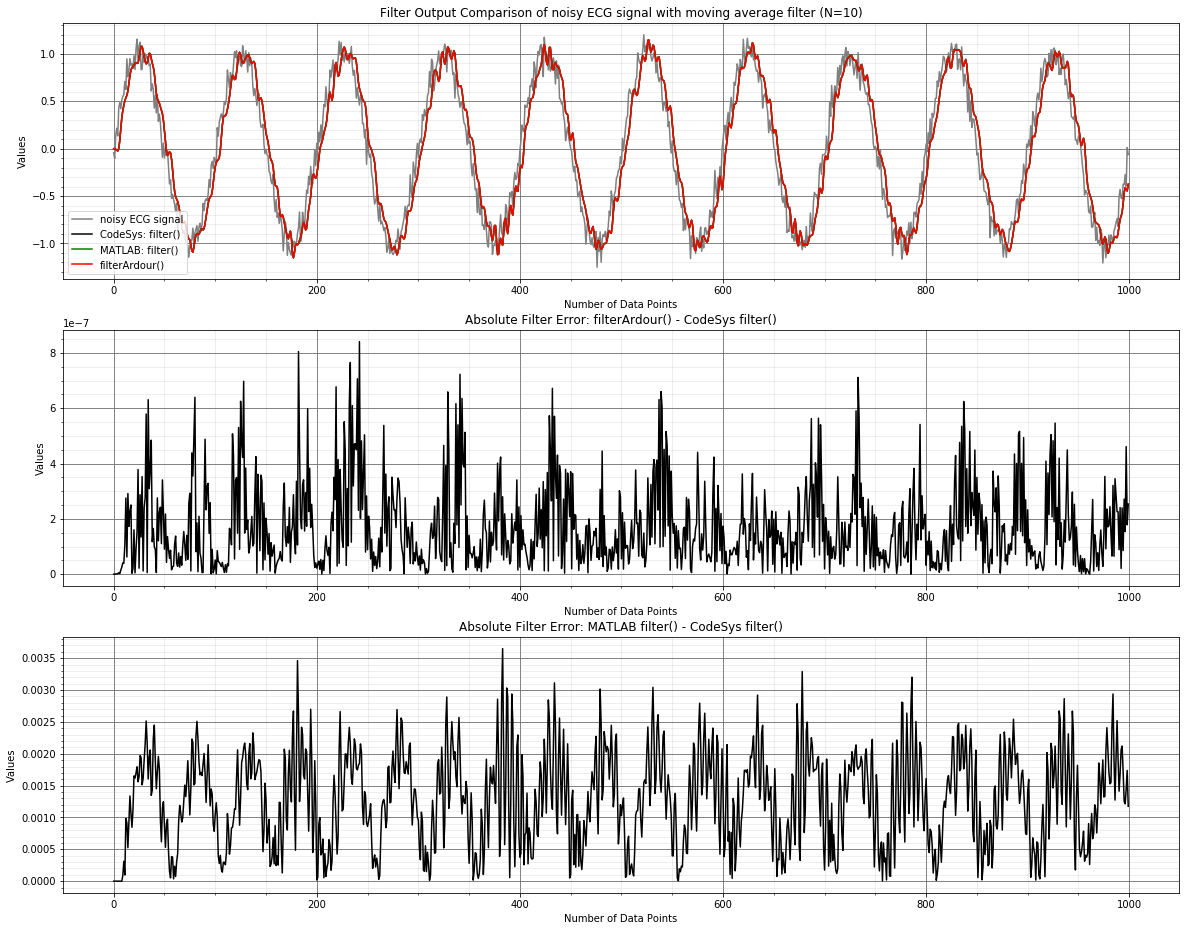

In [28]:
# plot comparison and error
fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(20,16))

ax0.plot(index[0:1000], inputSignal_noisy[0:1000], color='gray', label ='noisy ECG signal')
ax0.plot(index[0:1000], y_codesysFilter, color='black', label ='CodeSys: filter()')
ax0.plot(index[0:1000], y_matlabFilter[0:1000], color='green', label ='MATLAB: filter()')
ax0.plot(index[0:1000], y_filterArdour[0:1000], color='red', label ='filterArdour()')
ax1.plot(index[0:1000], codesys_filter_error_Ardour, color='black', label ='Filter Error')
ax2.plot(index[0:1000], codesys_filter_error_Matlab, color='black', label ='Filter Error')

ax0.set_title('Filter Output Comparison of noisy ECG signal with moving average filter (N=10)')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Absolute Filter Error: filterArdour() - CodeSys filter()')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax2.set_title('Absolute Filter Error: MATLAB filter() - CodeSys filter()')
ax2.set_xlabel('Number of Data Points')
ax2.set_ylabel('Values')
ax2.grid(b=True, which='major', color='#666666', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Plot comparison of MATLAB, Python and CodeSys "filtfilt" results

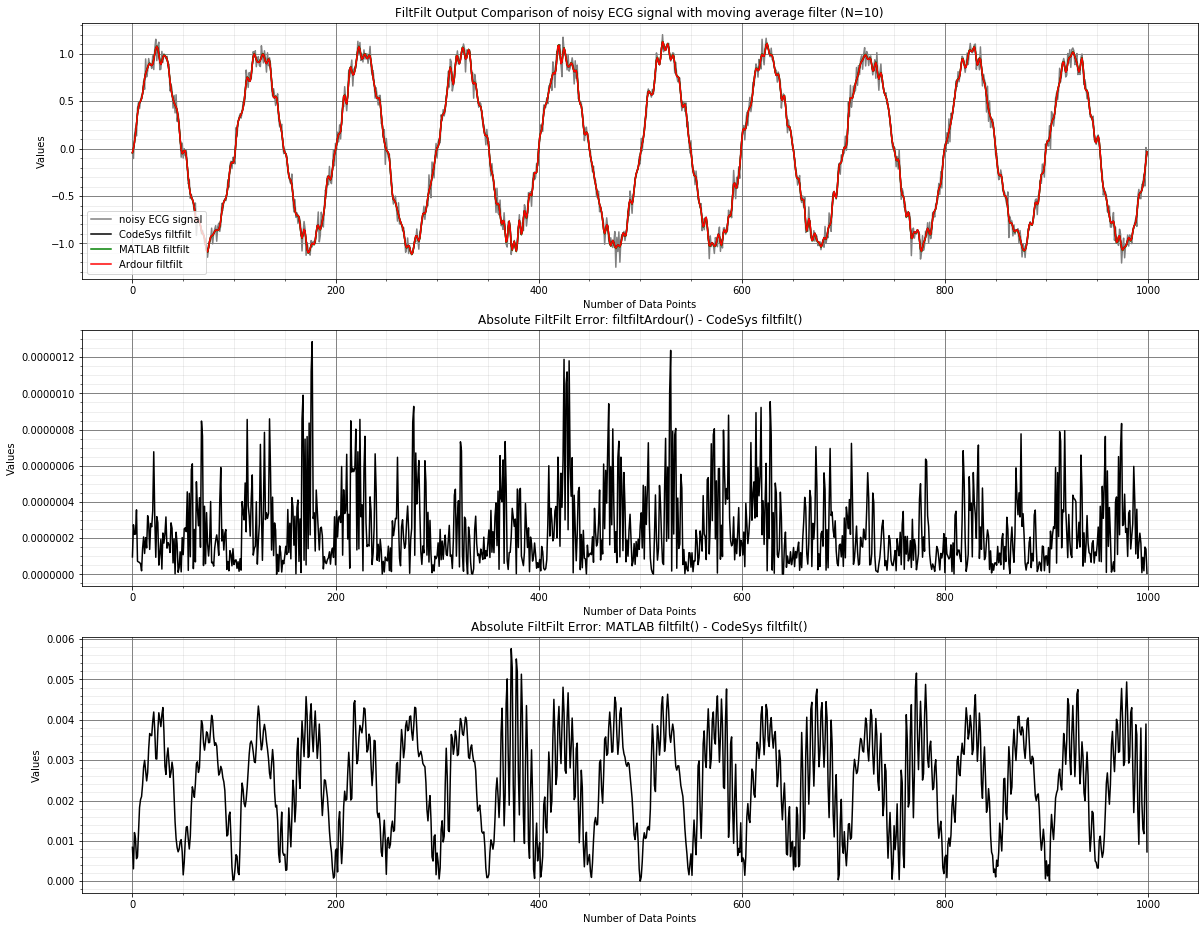

In [32]:
# plot comparison and error
fig, (ax0, ax1, ax2) = plt.subplots(3, figsize=(20,16))

ax0.plot(index[0:1000], inputSignal_noisy[0:1000], color='gray', label ='noisy ECG signal')
ax0.plot(index[0:1000], y_codesysFiltFilt, color='black', label ='CodeSys filtfilt')
ax0.plot(index[0:1000], y_matlabFiltFilt[0:1000], color='green', label ='MATLAB filtfilt')
ax0.plot(index[0:1000], y_filtfiltArdour[0:1000], color='red', label ='Ardour filtfilt')
ax1.plot(index[0:1000], codesys_filtfilt_error_Ardour, color='black', label ='Filtfilt Error')
ax2.plot(index[0:1000], codesys_filtfilt_error_Matlab, color='black', label ='Filtfilt Error')

ax0.set_title('FiltFilt Output Comparison of noisy ECG signal with moving average filter (N=10)')
ax0.set_xlabel('Number of Data Points')
ax0.set_ylabel('Values')
ax0.legend()
ax0.grid(b=True, which='major', color='#666666', linestyle='-')
ax0.minorticks_on()
ax0.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax1.set_title('Absolute FiltFilt Error: filtfiltArdour() - CodeSys filtfilt()')
ax1.set_xlabel('Number of Data Points')
ax1.set_ylabel('Values')
ax1.grid(b=True, which='major', color='#666666', linestyle='-')
ax1.minorticks_on()
ax1.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

ax2.set_title('Absolute FiltFilt Error: MATLAB filtfilt() - CodeSys filtfilt()')
ax2.set_xlabel('Number of Data Points')
ax2.set_ylabel('Values')
ax2.grid(b=True, which='major', color='#666666', linestyle='-')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)